In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data\Students Social Media Addiction.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (705, 13)

First 5 rows:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score

Target variable distributions:

Affects Academic Performance:
Affects_Academic_Performance
Yes    453
No     252
Name: count, dtype: int64

Addiction Score statistics:
count    705.000000
mean       6.436879
std        1.587165
min        2.000000
25%        5.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: Addicted_Score, dtype: float64


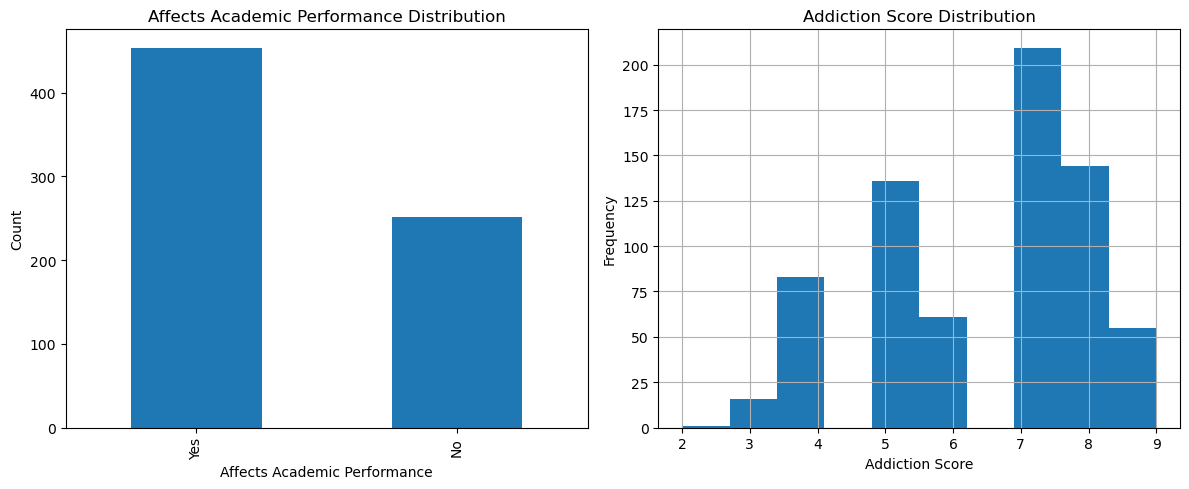

In [3]:
print("Target variable distributions:")
print("\nAffects Academic Performance:")
print(df['Affects_Academic_Performance'].value_counts())
print("\nAddiction Score statistics:")
print(df['Addicted_Score'].describe())

# Visualize target variables
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
df['Affects_Academic_Performance'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Affects Academic Performance Distribution')
axes[0].set_xlabel('Affects Academic Performance')
axes[0].set_ylabel('Count')

df['Addicted_Score'].hist(bins=10, ax=axes[1])
axes[1].set_title('Addiction Score Distribution')
axes[1].set_xlabel('Addiction Score')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
df_processed = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Relationship_Status']

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Convert target variable for classification
df_processed['Affects_Academic_Performance_encoded'] = LabelEncoder().fit_transform(df_processed['Affects_Academic_Performance'])

print("Encoded dataset shape:", df_processed.shape)
print("\nEncoded columns added:")
for col in categorical_columns:
    print(f"{col} -> {col}_encoded")

Encoded dataset shape: (705, 19)

Encoded columns added:
Gender -> Gender_encoded
Academic_Level -> Academic_Level_encoded
Country -> Country_encoded
Most_Used_Platform -> Most_Used_Platform_encoded
Relationship_Status -> Relationship_Status_encoded


In [5]:
# Select features for modeling
feature_columns = [
    'Age', 'Gender_encoded', 'Academic_Level_encoded', 'Country_encoded',
    'Avg_Daily_Usage_Hours', 'Most_Used_Platform_encoded', 'Sleep_Hours_Per_Night',
    'Mental_Health_Score', 'Relationship_Status_encoded', 'Conflicts_Over_Social_Media'
]

X = df_processed[feature_columns]
y_classification = df_processed['Affects_Academic_Performance_encoded']  # For classification
y_regression = df_processed['Addicted_Score']  # For regression

# Correlation analysis
correlation_with_academic = df_processed[feature_columns + ['Affects_Academic_Performance_encoded']].corr()['Affects_Academic_Performance_encoded'].abs().sort_values(ascending=False)
correlation_with_addiction = df_processed[feature_columns + ['Addicted_Score']].corr()['Addicted_Score'].abs().sort_values(ascending=False)

print("Features correlation with Academic Performance (absolute values):")
print(correlation_with_academic[:-1])
print("\nFeatures correlation with Addiction Score (absolute values):")
print(correlation_with_addiction[:-1])

Features correlation with Academic Performance (absolute values):
Affects_Academic_Performance_encoded    1.000000
Conflicts_Over_Social_Media             0.832030
Mental_Health_Score                     0.808921
Avg_Daily_Usage_Hours                   0.661474
Sleep_Hours_Per_Night                   0.625373
Most_Used_Platform_encoded              0.222285
Country_encoded                         0.182389
Age                                     0.137140
Relationship_Status_encoded             0.115705
Academic_Level_encoded                  0.036272
Name: Affects_Academic_Performance_encoded, dtype: float64

Features correlation with Addiction Score (absolute values):
Addicted_Score                 1.000000
Mental_Health_Score            0.945051
Conflicts_Over_Social_Media    0.933586
Avg_Daily_Usage_Hours          0.832000
Sleep_Hours_Per_Night          0.764858
Country_encoded                0.221383
Most_Used_Platform_encoded     0.209653
Age                            0.166396
Aca

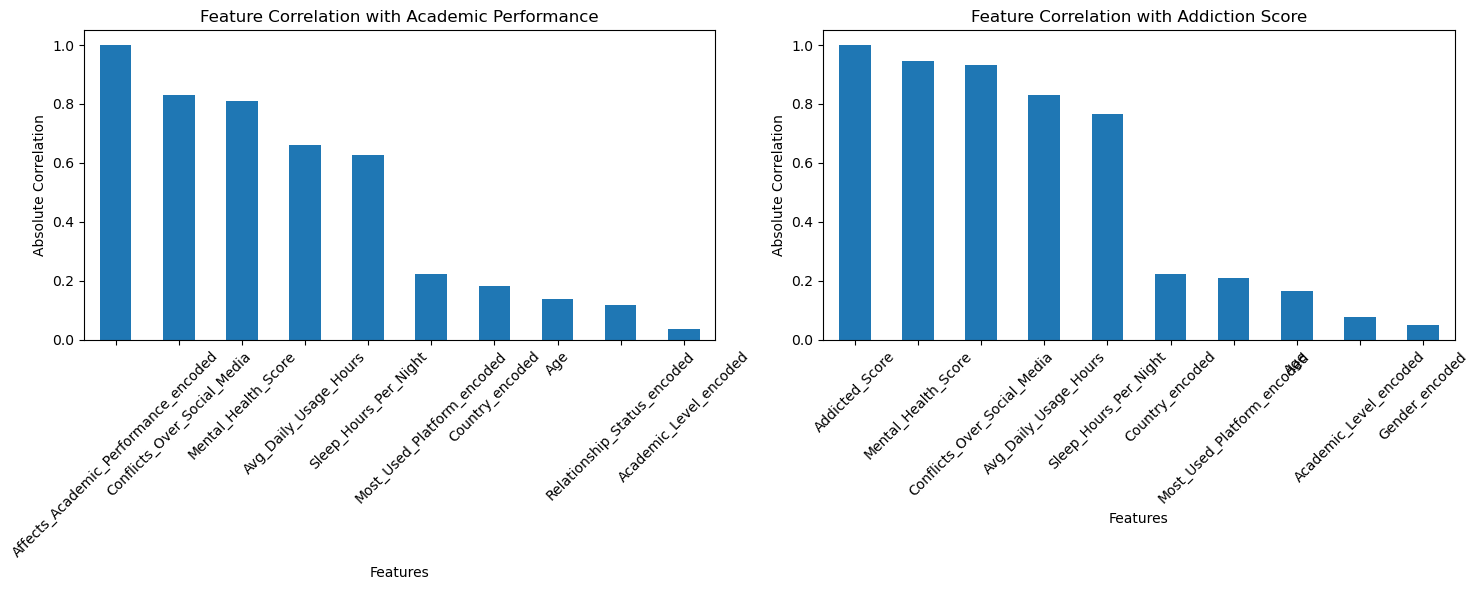

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Academic Performance correlations
correlation_with_academic[:-1].plot(kind='bar', ax=axes[0])
axes[0].set_title('Feature Correlation with Academic Performance')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Absolute Correlation')
axes[0].tick_params(axis='x', rotation=45)

# Addiction Score correlations
correlation_with_addiction[:-1].plot(kind='bar', ax=axes[1])
axes[1].set_title('Feature Correlation with Addiction Score')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Absolute Correlation')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [7]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for classification (Academic Performance)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split data for regression (Addiction Score)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_regression, test_size=0.2, random_state=42
)

print("Training set shape (Classification):", X_train_class.shape)
print("Test set shape (Classification):", X_test_class.shape)
print("Training set shape (Regression):", X_train_reg.shape)
print("Test set shape (Regression):", X_test_reg.shape)

Training set shape (Classification): (564, 10)
Test set shape (Classification): (141, 10)
Training set shape (Regression): (564, 10)
Test set shape (Regression): (141, 10)


In [8]:
classification_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42)
}

classification_results = {}

print("=== CLASSIFICATION MODELS FOR ACADEMIC PERFORMANCE ===\n")

for name, model in classification_models.items():
    # Train model
    model.fit(X_train_class, y_train_class)
    
    # Predictions
    y_pred = model.predict(X_test_class)
    
    # Accuracy
    accuracy = accuracy_score(y_test_class, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_class, y_train_class, cv=5)
    
    classification_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Classification Report:")
    print(classification_report(y_test_class, y_pred, target_names=['No', 'Yes']))
    print("-" * 50)


=== CLASSIFICATION MODELS FOR ACADEMIC PERFORMANCE ===

Random Forest:
  Accuracy: 1.0000
  CV Score: 1.0000 (+/- 0.0000)
  Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

--------------------------------------------------
Logistic Regression:
  Accuracy: 1.0000
  CV Score: 0.9982 (+/- 0.0071)
  Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

--------------------------------------------------


In [9]:
regression_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'SVR': SVR()
}

regression_results = {}

print("=== REGRESSION MODELS FOR ADDICTION SCORE ===\n")

for name, model in regression_models.items():
    # Train model
    model.fit(X_train_reg, y_train_reg)
    
    # Predictions
    y_pred = model.predict(X_test_reg)
    
    # Metrics
    mse = mean_squared_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    
    # Cross-validation (negative MSE, so we negate it)
    cv_scores = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    regression_results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")
    print("-" * 50)


=== REGRESSION MODELS FOR ADDICTION SCORE ===

Random Forest:
  RMSE: 0.2087
  R² Score: 0.9826
  CV RMSE: 0.2218 (+/- 0.0608)
--------------------------------------------------
Linear Regression:
  RMSE: 0.3544
  R² Score: 0.9498
  CV RMSE: 0.3769 (+/- 0.0921)
--------------------------------------------------
SVR:
  RMSE: 0.2935
  R² Score: 0.9656
  CV RMSE: 0.2967 (+/- 0.1097)
--------------------------------------------------


=== FEATURE IMPORTANCE (Random Forest) ===

For Academic Performance Classification:
                       feature  importance
9  Conflicts_Over_Social_Media    0.510051
7          Mental_Health_Score    0.252507
6        Sleep_Hours_Per_Night    0.115337
4        Avg_Daily_Usage_Hours    0.083171
3                      Country    0.018806
5           Most_Used_Platform    0.011979
8          Relationship_Status    0.003953
0                          Age    0.003070
1                       Gender    0.000736
2               Academic_Level    0.000390

For Addiction Score Regression:
                       feature  importance
7          Mental_Health_Score    0.833784
9  Conflicts_Over_Social_Media    0.118288
3                      Country    0.019848
6        Sleep_Hours_Per_Night    0.007502
4        Avg_Daily_Usage_Hours    0.007046
5           Most_Used_Platform    0.006851
0                          Age    0.002874
8          Relationship_Status    0.001849
2               Academ

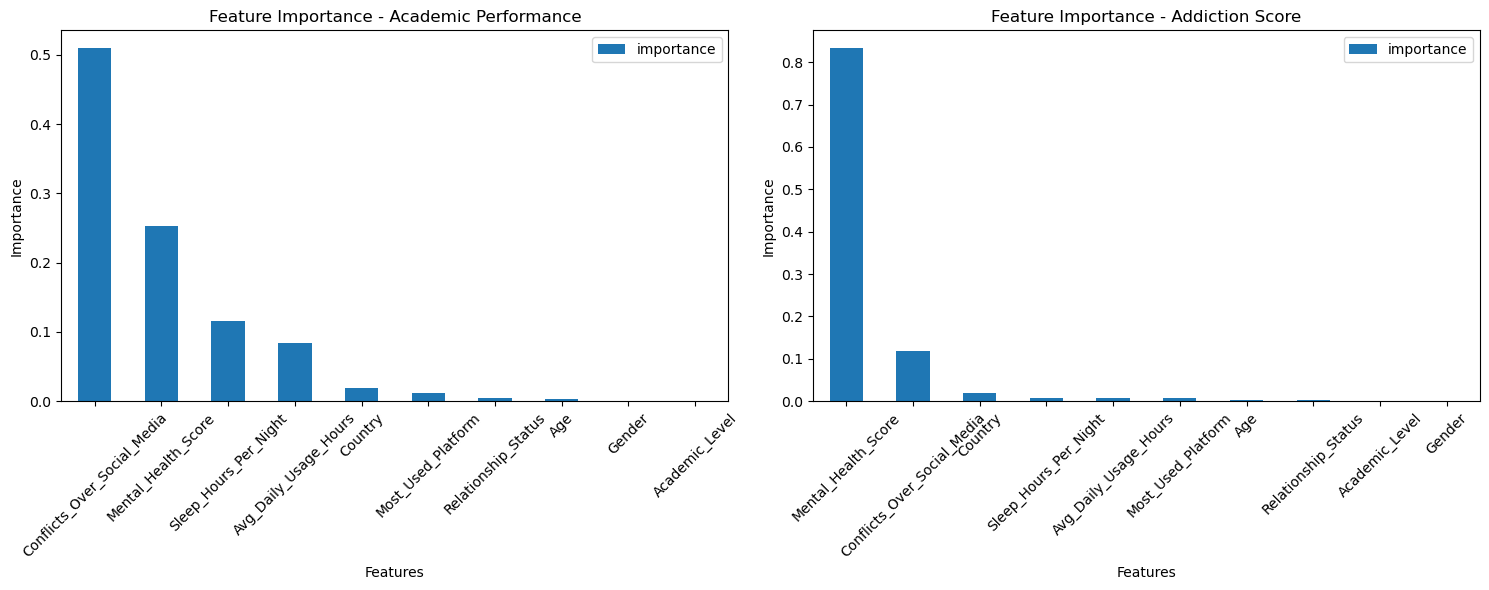

In [10]:
# Classification feature importance
rf_class = classification_results['Random Forest']['model']
feature_importance_class = pd.DataFrame({
    'feature': [col.replace('_encoded', '') for col in feature_columns],
    'importance': rf_class.feature_importances_
}).sort_values('importance', ascending=False)

# Regression feature importance
rf_reg = regression_results['Random Forest']['model']
feature_importance_reg = pd.DataFrame({
    'feature': [col.replace('_encoded', '') for col in feature_columns],
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("=== FEATURE IMPORTANCE (Random Forest) ===\n")
print("For Academic Performance Classification:")
print(feature_importance_class)
print("\nFor Addiction Score Regression:")
print(feature_importance_reg)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

feature_importance_class.plot(x='feature', y='importance', kind='bar', ax=axes[0])
axes[0].set_title('Feature Importance - Academic Performance')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].tick_params(axis='x', rotation=45)

feature_importance_reg.plot(x='feature', y='importance', kind='bar', ax=axes[1])
axes[1].set_title('Feature Importance - Addiction Score')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
print("=== HYPERPARAMETER TUNING ===\n")

# Best classification model hyperparameter tuning (Random Forest)
rf_class_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_class_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_class_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_class_grid.fit(X_train_class, y_train_class)
best_rf_class = rf_class_grid.best_estimator_

print("Best Classification Model (Random Forest):")
print(f"Best parameters: {rf_class_grid.best_params_}")
print(f"Best CV score: {rf_class_grid.best_score_:.4f}")

# Test the tuned model
y_pred_tuned_class = best_rf_class.predict(X_test_class)
tuned_accuracy = accuracy_score(y_test_class, y_pred_tuned_class)
print(f"Test accuracy: {tuned_accuracy:.4f}")

# Best regression model hyperparameter tuning (Random Forest)
rf_reg_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_reg_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_reg_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_reg_grid.fit(X_train_reg, y_train_reg)
best_rf_reg = rf_reg_grid.best_estimator_

print("\nBest Regression Model (Random Forest):")
print(f"Best parameters: {rf_reg_grid.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-rf_reg_grid.best_score_):.4f}")

# Test the tuned model
y_pred_tuned_reg = best_rf_reg.predict(X_test_reg)
tuned_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_tuned_reg))
tuned_r2 = r2_score(y_test_reg, y_pred_tuned_reg)
print(f"Test RMSE: {tuned_rmse:.4f}")
print(f"Test R²: {tuned_r2:.4f}")


=== HYPERPARAMETER TUNING ===

Best Classification Model (Random Forest):
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 1.0000
Test accuracy: 1.0000

Best Regression Model (Random Forest):
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (RMSE): 0.2234
Test RMSE: 0.2089
Test R²: 0.9826


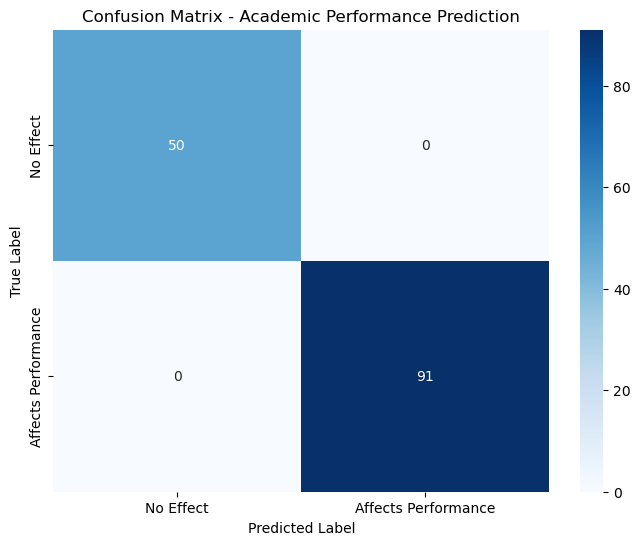

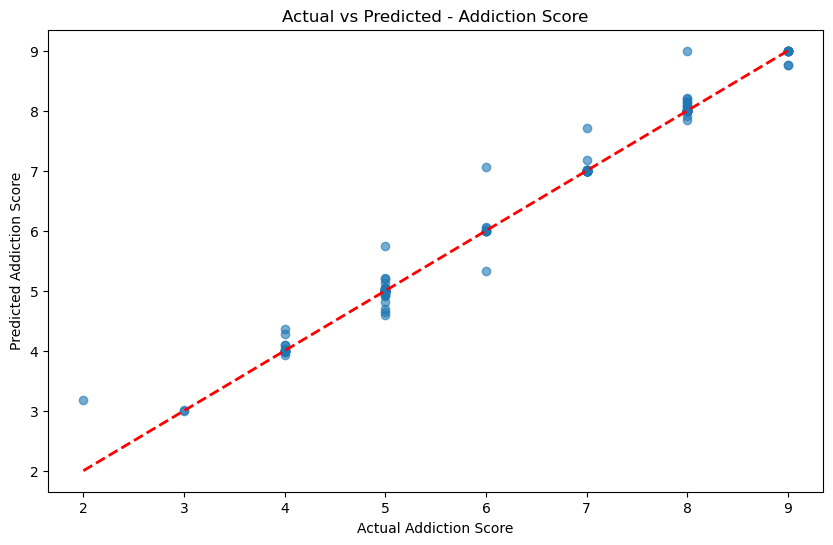

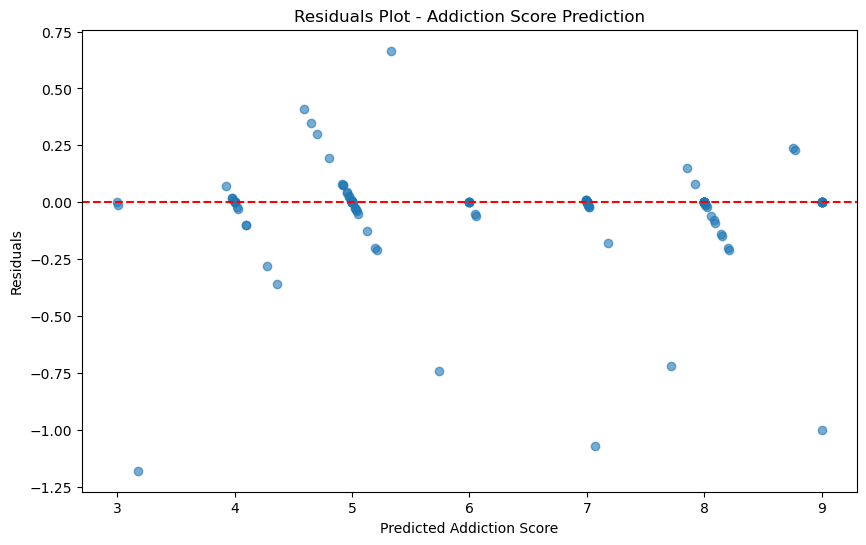

In [12]:
# Confusion matrix for classification
cm = confusion_matrix(y_test_class, y_pred_tuned_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Effect', 'Affects Performance'], 
            yticklabels=['No Effect', 'Affects Performance'])
plt.title('Confusion Matrix - Academic Performance Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Actual vs Predicted for regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_tuned_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Addiction Score')
plt.ylabel('Predicted Addiction Score')
plt.title('Actual vs Predicted - Addiction Score')
plt.show()

# Residuals plot
residuals = y_test_reg - y_pred_tuned_reg
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned_reg, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Addiction Score')
plt.ylabel('Residuals')
plt.title('Residuals Plot - Addiction Score Prediction')
plt.show()

In [13]:
print("=== SAVING MODELS ===\n")

# Save the best models
joblib.dump(best_rf_class, 'students_models/academic_performance_model.joblib')
joblib.dump(best_rf_reg, 'students_models/addiction_score_model.joblib')

# Save preprocessing objects
joblib.dump(scaler, 'students_models/feature_scaler.joblib')
joblib.dump(label_encoders, 'students_models/label_encoders.joblib')

# Save feature columns for reference
joblib.dump(feature_columns, 'students_models/feature_columns.joblib')

print("Models and preprocessing objects saved:")
print("- academic_performance_model.joblib")
print("- addiction_score_model.joblib")
print("- feature_scaler.joblib")
print("- label_encoders.joblib")
print("- feature_columns.joblib")

=== SAVING MODELS ===

Models and preprocessing objects saved:
- academic_performance_model.joblib
- addiction_score_model.joblib
- feature_scaler.joblib
- label_encoders.joblib
- feature_columns.joblib


In [15]:
def predict_social_media_impact(age, gender, academic_level, country, avg_daily_usage, 
                               platform, sleep_hours, mental_health_score, 
                               relationship_status, conflicts):
    """
    Function to predict both academic performance impact and addiction score
    """
    # Load models and preprocessing objects
    academic_model = joblib.load('students_models/academic_performance_model.joblib')
    addiction_model = joblib.load('students_models/addiction_score_model.joblib')
    scaler = joblib.load('students_models/feature_scaler.joblib')
    encoders = joblib.load('students_models/label_encoders.joblib')
    
    # Create input array
    input_data = np.array([[
        age,
        encoders['Gender'].transform([gender])[0],
        encoders['Academic_Level'].transform([academic_level])[0],
        encoders['Country'].transform([country])[0],
        avg_daily_usage,
        encoders['Most_Used_Platform'].transform([platform])[0],
        sleep_hours,
        mental_health_score,
        encoders['Relationship_Status'].transform([relationship_status])[0],
        conflicts
    ]])
    
    # Scale the input
    input_scaled = scaler.transform(input_data)
    
    # Make predictions
    academic_pred = academic_model.predict(input_scaled)[0]
    addiction_pred = addiction_model.predict(input_scaled)[0]
    
    # Convert academic prediction back to text
    academic_result = "Yes" if academic_pred == 1 else "No"
    
    return academic_result, round(addiction_pred, 2)

# Test the function
print("=== TESTING PREDICTION FUNCTION ===\n")
test_prediction = predict_social_media_impact(
    age=20, 
    gender='Female', 
    academic_level='Undergraduate', 
    country='USA',
    avg_daily_usage=6.0, 
    platform='Instagram', 
    sleep_hours=5.5, 
    mental_health_score=5,
    relationship_status='Single', 
    conflicts=4
)

print(f"Test prediction:")
print(f"Affects Academic Performance: {test_prediction[0]}")
print(f"Addiction Score: {test_prediction[1]}")


=== TESTING PREDICTION FUNCTION ===

Test prediction:
Affects Academic Performance: Yes
Addiction Score: 9.0


In [16]:
print("=== FINAL MODEL PERFORMANCE SUMMARY ===\n")

print("CLASSIFICATION MODEL (Academic Performance):")
print(f"Model: Random Forest with hyperparameter tuning")
print(f"Best parameters: {rf_class_grid.best_params_}")
print(f"Test Accuracy: {tuned_accuracy:.4f}")
print(f"Cross-validation Score: {rf_class_grid.best_score_:.4f}")

print(f"\nREGRESSION MODEL (Addiction Score):")
print(f"Model: Random Forest with hyperparameter tuning")
print(f"Best parameters: {rf_reg_grid.best_params_}")
print(f"Test RMSE: {tuned_rmse:.4f}")
print(f"Test R² Score: {tuned_r2:.4f}")
print(f"Cross-validation RMSE: {np.sqrt(-rf_reg_grid.best_score_):.4f}")

print(f"\nTOP 5 IMPORTANT FEATURES:")
print("For Academic Performance:")
for i, row in feature_importance_class.head().iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print("For Addiction Score:")
for i, row in feature_importance_reg.head().iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\nMODEL FILES SAVED:")
print("- academic_performance_model.joblib (Classification)")
print("- addiction_score_model.joblib (Regression)")
print("- feature_scaler.joblib (Feature scaling)")
print("- label_encoders.joblib (Categorical encoding)")
print("- feature_columns.joblib (Feature reference)")

print(f"\nREADY FOR FLASK INTEGRATION!")

=== FINAL MODEL PERFORMANCE SUMMARY ===

CLASSIFICATION MODEL (Academic Performance):
Model: Random Forest with hyperparameter tuning
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy: 1.0000
Cross-validation Score: 1.0000

REGRESSION MODEL (Addiction Score):
Model: Random Forest with hyperparameter tuning
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Test RMSE: 0.2089
Test R² Score: 0.9826
Cross-validation RMSE: 0.2234

TOP 5 IMPORTANT FEATURES:
For Academic Performance:
  10. Conflicts_Over_Social_Media: 0.5101
  8. Mental_Health_Score: 0.2525
  7. Sleep_Hours_Per_Night: 0.1153
  5. Avg_Daily_Usage_Hours: 0.0832
  4. Country: 0.0188
For Addiction Score:
  8. Mental_Health_Score: 0.8338
  10. Conflicts_Over_Social_Media: 0.1183
  4. Country: 0.0198
  7. Sleep_Hours_Per_Night: 0.0075
  5. Avg_Daily_Usage_Hours: 0.0070

MODEL FILES SAVED:
- academic_performance_model.joblib (Classification)
- addiction_score_